Mental Health Risk Prediction Model

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98       475
           1       0.97      0.96      0.97       359
           2       0.97      0.99      0.98      1166

    accuracy                           0.98      2000
   macro avg       0.98      0.97      0.98      2000
weighted avg       0.98      0.98      0.98      2000

Confusion Matrix:
 [[ 460    0   15]
 [   0  344   15]
 [   0    9 1157]]


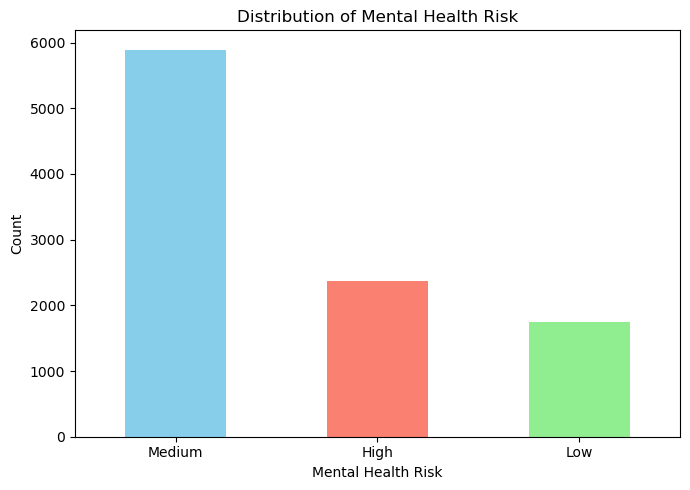

C:\Users\AI\AppData\Local\Temp\ipykernel_7888\1057188107.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='mental_health_risk', y='age', data=df_viz, palette='Set3')


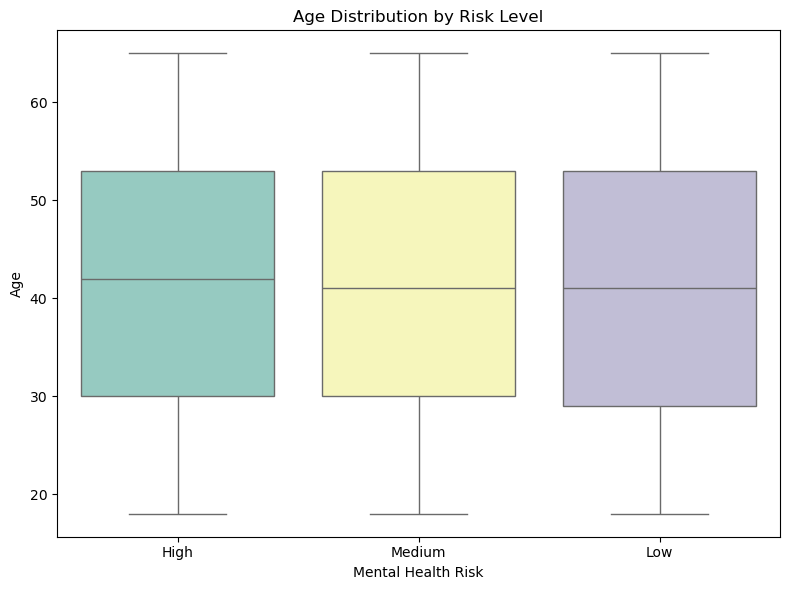

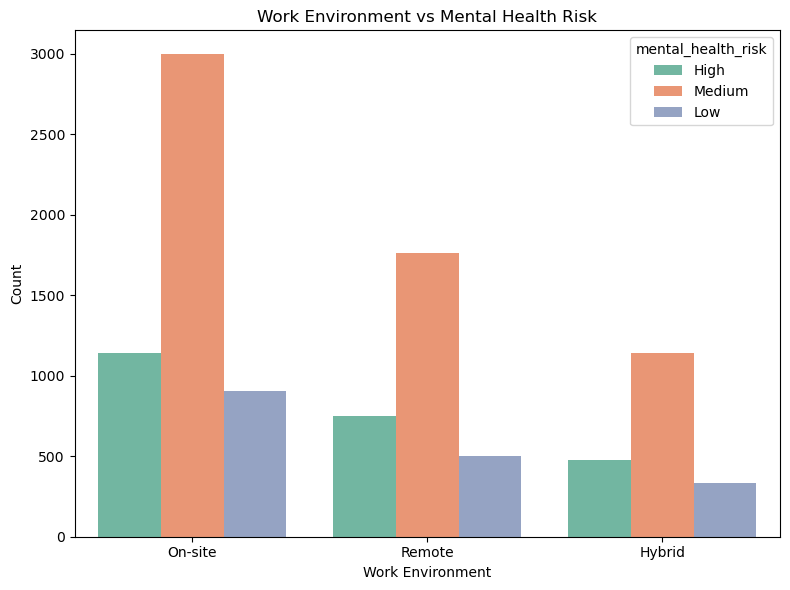

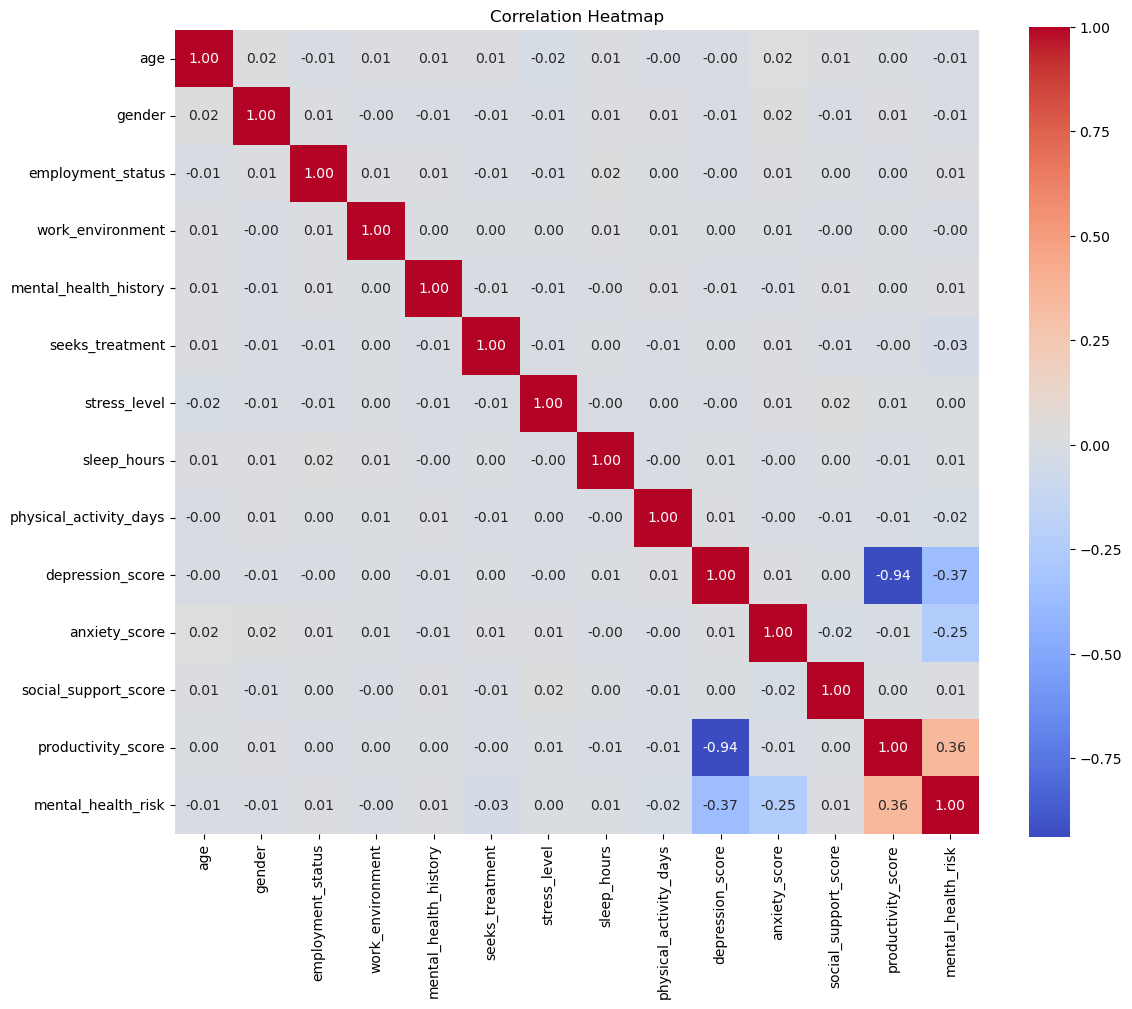

Predicted Risk: Medium (58.0%)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# 1. Load dataset
df = pd.read_csv('mental_health_dataset.csv')

# Backup for visualization before encoding
df_viz = df.copy()

# Drop null values (both datasets)
df.dropna(inplace=True)
df_viz.dropna(inplace=True)

# 2. Categorical and numerical columns
categorical_cols = ['gender', 'employment_status', 'work_environment',
                    'mental_health_history', 'seeks_treatment']

numerical_cols = ['age', 'stress_level', 'sleep_hours',
                  'physical_activity_days', 'depression_score',
                  'anxiety_score', 'social_support_score', 'productivity_score']

# 3. Encode categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Encode target column
target_encoder = LabelEncoder()
df['mental_health_risk'] = target_encoder.fit_transform(df['mental_health_risk'])

# 4. Split features and target
X = df.drop('mental_health_risk', axis=1)
y = df['mental_health_risk']

# 5. Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# 6. Save column structure for input prediction
joblib.dump(X.columns.tolist(), "model_features.pkl")

# 7. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Model training
model = RandomForestClassifier(n_estimators=150, random_state=42)
model.fit(X_train, y_train)

# 9. Evaluation
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 10. Save model and preprocessors
joblib.dump(model, 'mental_health_risk_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'encoders.pkl')
joblib.dump(target_encoder, 'target_encoder.pkl')

# -------------------------------
# 📊 Visualizations using df_viz
# -------------------------------

# 1. Class Distribution
plt.figure(figsize=(7, 5))
df_viz['mental_health_risk'].value_counts().plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Distribution of Mental Health Risk')
plt.xlabel('Mental Health Risk')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Age Distribution by Risk
plt.figure(figsize=(8, 6))
sns.boxplot(x='mental_health_risk', y='age', data=df_viz, palette='Set3')
plt.title('Age Distribution by Risk Level')
plt.xlabel('Mental Health Risk')
plt.ylabel('Age')
plt.tight_layout()
plt.show()

# 3. Work Environment vs Risk
plt.figure(figsize=(8, 6))
sns.countplot(x='work_environment', hue='mental_health_risk', data=df_viz, palette='Set2')
plt.title('Work Environment vs Mental Health Risk')
plt.xlabel('Work Environment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 4. Correlation Heatmap
df_encoded = df.copy()
plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# -------------------------------
# 🧠 Prediction Function
# -------------------------------

def predict_mental_health(input_data: dict):
    input_df = pd.DataFrame([input_data])

    # Load everything
    model = joblib.load("mental_health_risk_model.pkl")
    scaler = joblib.load("scaler.pkl")
    encoders = joblib.load("encoders.pkl")
    target_encoder = joblib.load("target_encoder.pkl")
    model_features = joblib.load("model_features.pkl")

    # Encode categorical
    for col in categorical_cols:
        if col in input_df.columns:
            value = input_df[col].iloc[0]
            if value in encoders[col].classes_:
                input_df[col] = encoders[col].transform([value])
            else:
                print(f"Warning: Unseen value '{value}' in column '{col}' - assigning 0")
                input_df[col] = 0

    # Scale numerical
    input_df[numerical_cols] = scaler.transform(input_df[numerical_cols])

    # Align with training columns
    input_df = input_df.reindex(columns=model_features, fill_value=0)

    # Predict
    prediction = model.predict(input_df)[0]
    confidence = model.predict_proba(input_df).max() * 100
    label = target_encoder.inverse_transform([prediction])[0]

    return label, round(confidence, 2)

# 🔍 Example usage
sample_input = {
    'age': 19,
    'gender': 'Female',
    'employment_status': 'Unemployed',
    'work_environment': 'On-site',
    'mental_health_history': 'No',
    'seeks_treatment': 'No',
    'stress_level': 1,
    'sleep_hours': 8.0,
    'physical_activity_days': 5,
    'depression_score': 10,
    'anxiety_score': 1,
    'social_support_score': 8,
    'productivity_score': 9.0
}

label, confidence = predict_mental_health(sample_input)
print(f"Predicted Risk: {label} ({confidence}%)")
